In [1]:
from Preprocess import *
from Model import *
from DataAnalysis import *

In [2]:
dic_csv = read_data()
df_var = make_dataframe(dic_csv)

In [3]:
concat_train_test(dic_csv, df_var)
loans = Merge(df_var, haveCategorical=False)

In [4]:
handle_non_numeric_data(loans)
original_loan_per_year = loan_per_year(loans, haveCategorical= False, isMerged = True)

In [5]:
#df = pd.concat([original_loan_per_year[1993].copy(),original_loan_per_year[1994].copy(),original_loan_per_year[1995].copy(),])
#df = original_loan_per_year[1993].copy()
#X_train = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
#y_train = df['status'].copy()
    
#best_score, best_params = ClassifierDecisionTree(X_train, y_train)

In [6]:
#df = loans[loans['status'] != 'none'].copy()
#X_train = df.drop(columns=['status', 'year', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
#y_train = df['status'].copy()
#best_score, best_params, cv_results = ClassifierDecisionTree(X_train, y_train)


Accuracy: 0.45544554455445546
Precision: 0.8478260869565217
Recall: 0.4482758620689655
F1score: 0.6917293233082706


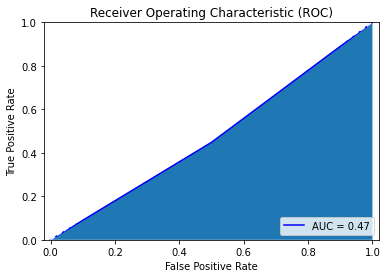

In [7]:
classifier = DecisionTreeClassifier(class_weight="balanced", criterion='gini', max_depth=2, max_features='auto', min_impurity_split=0.05, min_samples_leaf=1, min_samples_split=2, splitter='best')
classifier = apply_sampling(classifier)
df = original_loan_per_year[1993].copy()
X_train = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
y_train = df['status'].copy()
normalize_columns(X_train, X_train.columns)
classifier.fit(X_train, y_train.astype(int))
df = original_loan_per_year[1994].copy()
X_test = df.drop(columns=['status', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
y_test = df['status'].copy()
normalize_columns(X_test, X_test.columns)
y_pred = classifier.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test.astype(int), y_pred)
auc = metrics.auc(fpr, tpr)
from sklearn.metrics import confusion_matrix
#print(auc)normalize_columns(X_test, X_test.columns)
tn, fp, fn, tp = confusion_matrix(y_test.astype(int), y_pred).ravel()
print()
print('Accuracy: {}'.format(accuracy(tp,tn,fp,fn)))
print('Precision: {}'.format(precision(tp,fp)))
print('Recall: {}'.format(recall(tp,fn)))
print('F1score: {}'.format(f1score(tp,fp,fn)))
plot_roc_auc(fpr, tpr, auc)

In [8]:

#normalize_columns(Xavel()_train, X_train.columns)
df = loans[loans['status'] == 'none'].copy()
X_test = df.drop(columns=['status', 'year', 'loan_id', 'account_id', "unemploymant rate '95 ", 'card_type', 'name', 'operation_n_credit_card_withdrawal'], axis=1)
normalize_columns(X_test, X_test.columns)